In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

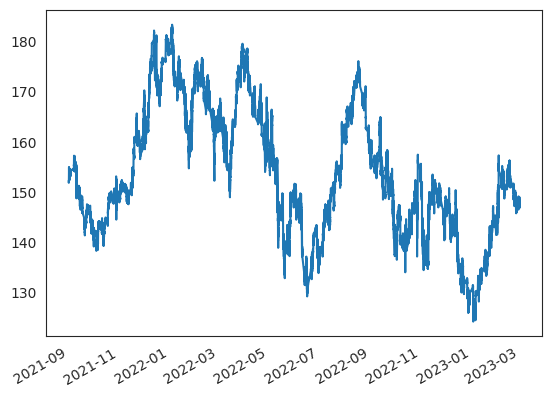

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_9,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,psar_dir,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,151.953148,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.31,151.82,0.000000,0.003217,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,84.482759,94.827586,84.482759,94.827586,466.666667,657.602451,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,1,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.024518,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.31,151.82,0.000000,0.003217,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,84.482759,89.655172,84.482759,89.655172,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,1,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.079614,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44.722948,76.313395,8.649316,27.633299,69.132130,12.694655,18.306713,151.598286,152.246714,0.004268,151.436178,152.408822,0.006402,151.645288,152.092112,0.0029

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df = df_inds # SELECT THE CORRECT DATAFRAME
df.close.plot()
plt.show()
df

In [5]:
trading_combinations = {
    # EMA based
    # "tc_ema_3_8":     {"col_signal": "ema_3",    "sign_thresh": "ema_8"},
    # "tc_ema_5_13":   {"col_signal": "ema_5",    "sign_thresh": "ema_13"},
    "tc_ema_9_21":   {"col_signal": "ema_9",    "sign_thresh": "ema_21"},
    "tc_ema_21_50":  {"col_signal": "ema_21",    "sign_thresh": "ema_50"},
    
    # # ROC based
    # "tc_roc5_ema21": {"col_signal": "roc_5",    "sign_thresh": "ema_21"},
    # "tc_roc5_zero":  {"col_signal": "roc_5",    "sign_thresh": 0.0},
    # # MACD-based:
    # "tc_macd_line":  {"col_signal": "macd_line_12_26_9", "sign_thresh": 0.0},
    # "tc_macd_diff":  {"col_signal": "macd_diff_6_13_5",  "sign_thresh": 0.0},
    # # RSI gate as signal:
    # "tc_rsi_mid":    {"col_signal": "rsi_14",   "sign_thresh": 50.0},
    # "tc_rsi_fast":   {"col_signal": "rsi_6",    "sign_thresh": 50.0},

}

In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:

    trad_comb = trading_combinations[
        trial.suggest_categorical("tc_id", list(trading_combinations.keys()))
    ]
    
    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    
    # RSI band
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 20, 60)
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 50), 100)
    # Volume spike threshold (ratio-ish)
    vol_thresh     = trial.suggest_float("vol_thresh", 3.0, 6.0)
    # Trend filter
    adx_thresh     = trial.suggest_float("adx_thresh", 30.0, 60.0)
    # ATR multipliers (log for breadth)
    atr_mult       = trial.suggest_float("atr_mult", 1.0, 6.0, log=True)
    # VWAP+ATR gate; allow negative/positive tilt
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -20.0, 5.0)
    # Scaling factors (wire these into your strategy if used)
    buy_factor     = trial.suggest_float("buy_factor", 0.1, 1.0)
    sell_factor    = trial.suggest_float("sell_factor", 0.1, 1.0)
    # Trailing stop percentage (as percent; kept wider but sane)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 3.0, 15.0)
    
    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = trad_comb["col_signal"],
            sign_thresh     = trad_comb["sign_thresh"],
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_vol_spike   = params.col_vol_spike_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            vol_thresh      = vol_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            # sess_start      = params.sess_start_tick
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)




Baseline mean daily B&H: -9.5162


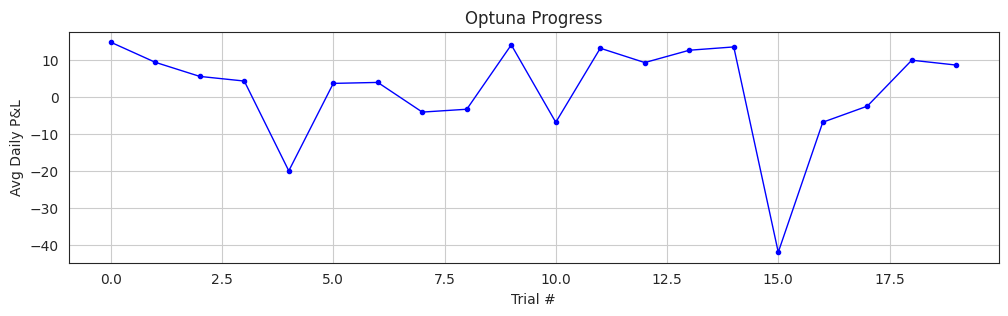

/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=100; vol_thresh=4.363670252785925; adx_thresh=54.01881853220799; atr_mult=1.941961832887694; vwap_atr_mult=3.412364980346073; buy_factor=0.5451546225309478; sell_factor=0.18753688121794093; trailstop_pct=14.567404856628437


Trial 0: 100%|██████████| 375/375 [00:34<00:00, 10.74it/s]


[Results] mean_pnl:6.1108 mean_bh:-8.7491 mean_excess:14.8599 improv_vs_bh:169.85%
Action counts: {'Buy': 30, 'Sell': 561, 'Hold': 350120}
Best trial is: 0 with best_val: 14.8599
[save_results] wrote optuna_results/AAPL_14.8599_predicted.csv
[save_best_json] wrote optuna_results/AAPL_14.8599_predicted.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=73; vol_thresh=3.649591044936905; adx_thresh=50.38796929310851; atr_mult=2.9873652816709937; vwap_atr_mult=-7.495080707855557; buy_factor=0.16130279258475616; sell_factor=0.23731902228371302; trailstop_pct=10.11395542750846


Trial 1: 100%|██████████| 375/375 [00:28<00:00, 13.17it/s]


[Results] mean_pnl:0.6845 mean_bh:-8.7491 mean_excess:9.4336 improv_vs_bh:107.82%
Action counts: {'Buy': 74, 'Sell': 840, 'Hold': 349797}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=65; vol_thresh=3.82978686615607; adx_thresh=45.455101506646024; atr_mult=1.0096688249674268; vwap_atr_mult=-3.1452087586202566; buy_factor=0.7771814288099411; sell_factor=0.46296182824478815; trailstop_pct=13.061712635040074


Trial 2: 100%|██████████| 375/375 [00:25<00:00, 14.66it/s]


[Results] mean_pnl:-3.1237 mean_bh:-8.7491 mean_excess:5.6254 improv_vs_bh:64.30%
Action counts: {'Buy': 134, 'Sell': 967, 'Hold': 349610}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; vol_thresh=4.603324994342719; adx_thresh=42.15938594192474; atr_mult=5.240655587671393; vwap_atr_mult=-14.815424418546897; buy_factor=0.22464906111869237; sell_factor=0.9995066381557968; trailstop_pct=9.730633831542846


Trial 3: 100%|██████████| 375/375 [00:25<00:00, 14.84it/s]


[Results] mean_pnl:-4.3767 mean_bh:-8.7491 mean_excess:4.3724 improv_vs_bh:49.97%
Action counts: {'Buy': 121, 'Sell': 103, 'Hold': 350487}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=89; vol_thresh=4.9279475421177885; adx_thresh=32.84100338986013; atr_mult=1.219371940825509; vwap_atr_mult=-19.349327046633448; buy_factor=0.4518728085633692; sell_factor=0.9837729157231845; trailstop_pct=14.101532462163835


Trial 4: 100%|██████████| 375/375 [00:25<00:00, 14.97it/s]


[Results] mean_pnl:-28.6378 mean_bh:-8.7491 mean_excess:-19.8887 improv_vs_bh:-227.32%
Action counts: {'Buy': 260, 'Sell': 454, 'Hold': 349997}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=78; vol_thresh=3.6900142220211665; adx_thresh=49.81281279227765; atr_mult=2.5401093730992756; vwap_atr_mult=-1.3157260297047202; buy_factor=0.8572806241048182; sell_factor=0.49109692672131366; trailstop_pct=14.560624139814044


Trial 5: 100%|██████████| 375/375 [00:26<00:00, 14.01it/s]


[Results] mean_pnl:-5.0083 mean_bh:-8.7491 mean_excess:3.7408 improv_vs_bh:42.76%
Action counts: {'Buy': 74, 'Sell': 562, 'Hold': 350075}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=69; vol_thresh=4.649124714739063; adx_thresh=46.266009425410914; atr_mult=1.570707279545461; vwap_atr_mult=0.9295231195684792; buy_factor=0.46250329520387345; sell_factor=0.6431225271302026; trailstop_pct=8.440783478803505


Trial 6: 100%|██████████| 375/375 [00:27<00:00, 13.84it/s]


[Results] mean_pnl:-4.7486 mean_bh:-8.7491 mean_excess:4.0005 improv_vs_bh:45.72%
Action counts: {'Buy': 67, 'Sell': 355, 'Hold': 350289}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; vol_thresh=5.08551914246127; adx_thresh=43.86014570394071; atr_mult=2.418335868631781; vwap_atr_mult=-6.336501149117176; buy_factor=0.5741676653328703; sell_factor=0.7496503427493748; trailstop_pct=6.706080303479666


Trial 7: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:-12.7616 mean_bh:-8.7491 mean_excess:-4.0125 improv_vs_bh:-45.86%
Action counts: {'Buy': 78, 'Sell': 358, 'Hold': 350275}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=80; vol_thresh=5.93907540120105; adx_thresh=35.716614301328526; atr_mult=5.166645538682566; vwap_atr_mult=-16.239958429459453; buy_factor=0.7247014942597902; sell_factor=0.24677058845793928; trailstop_pct=6.881846366197232


Trial 8: 100%|██████████| 375/375 [00:26<00:00, 14.11it/s]


[Results] mean_pnl:-11.9919 mean_bh:-8.7491 mean_excess:-3.2428 improv_vs_bh:-37.06%
Action counts: {'Buy': 152, 'Sell': 2641, 'Hold': 347918}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=80; vol_thresh=3.6540806649275477; adx_thresh=51.971293844600055; atr_mult=3.120060704466129; vwap_atr_mult=-13.76354027723994; buy_factor=0.9912127921700469; sell_factor=0.6347563700777988; trailstop_pct=4.054072483464781


Trial 9: 100%|██████████| 375/375 [00:22<00:00, 16.84it/s]


[Results] mean_pnl:5.3982 mean_bh:-8.7491 mean_excess:14.1473 improv_vs_bh:161.70%
Action counts: {'Buy': 59, 'Sell': 322, 'Hold': 350330}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=89; vol_thresh=5.81391078179984; adx_thresh=34.64584292105099; atr_mult=3.557189978683321; vwap_atr_mult=2.55302047766833; buy_factor=0.8893661118149873; sell_factor=0.14439809185029567; trailstop_pct=3.130166609187696


Trial 10: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:-15.5166 mean_bh:-8.7491 mean_excess:-6.7675 improv_vs_bh:-77.35%
Action counts: {'Buy': 165, 'Sell': 4183, 'Hold': 346363}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=78; vol_thresh=3.9997985013875907; adx_thresh=53.838720000827145; atr_mult=3.8787292908498983; vwap_atr_mult=-2.507259524222107; buy_factor=0.31172153203591524; sell_factor=0.10382955166495772; trailstop_pct=9.878525889083075


Trial 11: 100%|██████████| 375/375 [00:27<00:00, 13.62it/s]


[Results] mean_pnl:4.4910 mean_bh:-8.7491 mean_excess:13.2401 improv_vs_bh:151.33%
Action counts: {'Buy': 35, 'Sell': 931, 'Hold': 349745}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=64; vol_thresh=4.708387880419551; adx_thresh=53.994479005889836; atr_mult=1.3210569791751472; vwap_atr_mult=-5.005260984606586; buy_factor=0.28301209984217474; sell_factor=0.2202869626945962; trailstop_pct=6.1713839258284136


Trial 12: 100%|██████████| 375/375 [00:32<00:00, 11.45it/s]


[Results] mean_pnl:0.6139 mean_bh:-8.7491 mean_excess:9.3630 improv_vs_bh:107.02%
Action counts: {'Buy': 24, 'Sell': 332, 'Hold': 350355}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=54; rsi_max_thresh=89; vol_thresh=5.738289332784158; adx_thresh=45.47118443660296; atr_mult=1.4047516631875618; vwap_atr_mult=-0.8824269104787312; buy_factor=0.8590555299443267; sell_factor=0.8368865902461372; trailstop_pct=3.3538522585404746


Trial 13: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


[Results] mean_pnl:3.9454 mean_bh:-8.7491 mean_excess:12.6945 improv_vs_bh:145.09%
Action counts: {'Buy': 56, 'Sell': 200, 'Hold': 350455}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=95; vol_thresh=3.377759929393359; adx_thresh=58.49363079433135; atr_mult=1.2874443309509653; vwap_atr_mult=1.0924676420046069; buy_factor=0.46326120337193544; sell_factor=0.9517169232958641; trailstop_pct=12.23890166488642


Trial 14: 100%|██████████| 375/375 [00:42<00:00,  8.90it/s]


[Results] mean_pnl:4.8397 mean_bh:-8.7491 mean_excess:13.5888 improv_vs_bh:155.32%
Action counts: {'Buy': 27, 'Sell': 47, 'Hold': 350637}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=76; vol_thresh=3.8429204110611552; adx_thresh=31.56040578316712; atr_mult=2.313584787638664; vwap_atr_mult=-14.316888649714056; buy_factor=0.6057912085836938; sell_factor=0.9748538364053108; trailstop_pct=6.660454443482438


Trial 15: 100%|██████████| 375/375 [00:27<00:00, 13.51it/s]


[Results] mean_pnl:-50.6137 mean_bh:-8.7491 mean_excess:-41.8646 improv_vs_bh:-478.50%
Action counts: {'Buy': 515, 'Sell': 672, 'Hold': 349524}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=84; vol_thresh=4.008872734539418; adx_thresh=33.57105375197759; atr_mult=1.51569020923757; vwap_atr_mult=-4.857064702796231; buy_factor=0.2172327174750689; sell_factor=0.14463601465977646; trailstop_pct=11.30460005886667


Trial 16: 100%|██████████| 375/375 [00:27<00:00, 13.82it/s]


[Results] mean_pnl:-15.5022 mean_bh:-8.7491 mean_excess:-6.7531 improv_vs_bh:-77.19%
Action counts: {'Buy': 381, 'Sell': 6836, 'Hold': 343494}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=94; vol_thresh=5.762700009802439; adx_thresh=37.81713337798068; atr_mult=2.6981773171319285; vwap_atr_mult=-4.013408589929684; buy_factor=0.4885770372024103; sell_factor=0.9921361380723882; trailstop_pct=11.301270609397534


Trial 17: 100%|██████████| 375/375 [00:32<00:00, 11.70it/s]


[Results] mean_pnl:-11.1635 mean_bh:-8.7491 mean_excess:-2.4144 improv_vs_bh:-27.60%
Action counts: {'Buy': 127, 'Sell': 232, 'Hold': 350352}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=46; rsi_max_thresh=58; vol_thresh=3.5386872206488253; adx_thresh=52.226399338435286; atr_mult=1.2688706643252348; vwap_atr_mult=-11.211901875672893; buy_factor=0.21997259822183435; sell_factor=0.537407293217207; trailstop_pct=9.61112660897434


Trial 18: 100%|██████████| 375/375 [00:26<00:00, 14.07it/s]


[Results] mean_pnl:1.2529 mean_bh:-8.7491 mean_excess:10.0020 improv_vs_bh:114.32%
Action counts: {'Buy': 65, 'Sell': 313, 'Hold': 350333}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=98; vol_thresh=4.699122836067016; adx_thresh=48.47911760149597; atr_mult=3.68100549002917; vwap_atr_mult=1.406284170739461; buy_factor=0.7360204275697345; sell_factor=0.1847326955245237; trailstop_pct=14.235404272879311


Trial 19: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:-0.0612 mean_bh:-8.7491 mean_excess:8.6879 improv_vs_bh:99.30%
Action counts: {'Buy': 57, 'Sell': 1212, 'Hold': 349442}
Best trial is: 0 with best_val: 14.8599
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=85; vol_thresh=3.9570566303709587; adx_thresh=48.59393843606637; atr_mult=3.2810175731856295; vwap_atr_mult=-3.4257871666020847; buy_factor=0.2411424497853369; sell_factor=0.5322482977535895; trailstop_pct=4.6847191218568796


Trial 20:  65%|██████▌   | 245/375 [00:14<00:06, 19.20it/s]

In [ ]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
trials_before_pruning = 100
trials_of_exploration = 100
n_jobs = 1

reports_per_trial = math.ceil(len(groups) / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("predicted")
cb_save_json = opts.make_save_best_json_callback("predicted")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()